In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from easydict import EasyDict as edict
from xml.etree.ElementTree import parse as parse_xml
import cv2
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import os.path as osp

# Configurations

In [3]:
cfg = edict()

# Anchor box setting
cfg.ACNHOR_BASE_SIZE = 16
cfg.ANCHOR_SCALES = [8, 16, 32]
cfg.ANCHOR_RATIOS = [0.5, 1, 2]
cfg.NUM_ANCHORS_PER_GRID = len(cfg.ANCHOR_SCALES) * len(cfg.ANCHOR_RATIOS)

cfg.IS_TRAINING = True

cfg.TRAIN = edict()
cfg.TRAIN.WEIGHT_DECAY = 0.0001
cfg.TRAIN.RPN_POST_NMS_TOP_N = 2000
cfg.TRAIN.RPN_NMS_THRES = 0.7
cfg.TRAIN.RPN_CLOBBER_POSITIVES = False
cfg.TRAIN.RPN_NEGATIVE_OVERLAP = 0.3
cfg.TRAIN.RPN_POSITIVE_OVERLAP = 0.7
cfg.TRAIN.RPN_FG_FRACTION = 0.5
cfg.TRAIN.RPN_BATCHSIZE = 256
cfg.TRAIN.RPN_BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)
cfg.TRAIN.RPN_POSITIVE_WEIGHT = -1
cfg.TRAIN.BATCH_SIZE = 256
cfg.TRAIN.FG_FRACTION = 0.25
cfg.TRAIN.FG_THRESH = 0.7
cfg.TRAIN.BG_THRESH_HI = 0.5
cfg.TRAIN.BG_THRESH_LO = 0.0
cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED = True
cfg.TRAIN.BBOX_NORMALIZE_MEANS = (0.0, 0.0, 0.0, 0.0)
cfg.TRAIN.BBOX_NORMALIZE_STDS = (0.1, 0.1, 0.2, 0.2)
cfg.TRAIN.BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)

cfg.TEST = edict()
cfg.TEST.RPN_POST_NMS_TOP_N = 300
cfg.TEST.RPN_NMS_THRES = 0.7

cfg.ARCHI = edict()
cfg.ARCHI.NET_NAME = 'vgg_16'
cfg.ARCHI.TOTAL_STRIDE = 16
cfg.ARCHI.RPN_CHANNELS = 512
cfg.ARCHI.POOLING_SIZE = 7

cfg.PIXEL_MEANS = [102.9801, 115.9465, 122.7717]

In [4]:
sess = tf.InteractiveSession()

# Dictionaries for tensors

In [5]:
inputs = dict()
predictions = dict()
intermediates = dict()
checkups = dict()

In [6]:
targets = dict()

# 1. Inputs Definition

In [7]:
inputs.update(
    {
        'image': tf.placeholder(tf.float32, shape=(1, None, None, 3)),  # [height, width, channel]
        'image_size': tf.placeholder(tf.float32, shape=[2]),  # [height, width]
        'image_scale': tf.placeholder(tf.float32, shape=[1]),
        'gt_boxes': tf.placeholder(tf.float32, shape=[None, 5])  # [[xmin, ymin, xmax, ymax, cls_idx], ...]
    }
)

# 2. Sample Data Preparation

In [8]:
DATASET_DIR = '/home/jongho/data/VOCdevkit/VOC2007'

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]  # background class(일반적으로 0번에 위치함)와 20개의 object class -> 총 21개의 클래스로 구성

# Dataset-related configurations
cfg.DATA = edict()
cfg.DATA.NUM_CLASSES = len(VOC_CLASSES)
cfg.DATA.NUM_OBJ_CLASSES = cfg.DATA.NUM_CLASSES - 1
cfg.DATA.IMG_SHORTER_SIDE = 600

### Read a single sample from VOC2007.

In [9]:
def _voc_cls_name_to_idx(name):
    idx = dict(list(zip(VOC_CLASSES, list(range(len(VOC_CLASSES))))))[name]
    return idx

sample_id = '000330'

# Read the image file.
img = cv2.imread(osp.join(DATASET_DIR, 'JPEGImages/{}.jpg'.format(sample_id)))

# Read and parse the corresponding annotation file.
anno = parse_xml(osp.join(DATASET_DIR, 'Annotations/{}.xml'.format(sample_id))).getroot()
gt_boxes = []
for obj in anno.findall('object'):
    bndbox = obj.find('bndbox')
    bbox = [float(bndbox.find('xmin').text) - 1,
            float(bndbox.find('ymin').text) - 1,
            float(bndbox.find('xmax').text) - 1,
            float(bndbox.find('ymax').text) - 1,
            _voc_cls_name_to_idx(obj.find('name').text)]
    gt_boxes.append(bbox)
gt_boxes = np.array(gt_boxes, dtype=np.float32)

# Resize the image and rescale the GT boxes accordingly.
img_size_min = np.min(img.shape[:2])
img_scale = cfg.DATA.IMG_SHORTER_SIDE / img_size_min
img = cv2.resize(img, None, None, fx=img_scale, fy=img_scale, interpolation=cv2.INTER_LINEAR)
img_size = img.shape[:2]
gt_boxes[:, :4] *= img_scale

### Look into the sample.

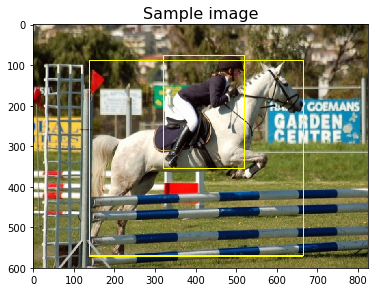


GT boxes:
[[321.49      77.3639   520.91693  355.87393   15.      ]
 [139.25502   89.398285 665.3295   570.7737    13.      ]]

Image size: (600, 825)

Image scale: 1.7191977077363896


In [10]:
def _draw_boxes_on_image(img, boxes):
    _img = img.copy()
    for box in boxes:
        cv2.rectangle(_img, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 255), thickness=2)
    return _img

# Visualize the sample instance.
img_boxed = _draw_boxes_on_image(img, gt_boxes)

plt.figure(figsize=(6, 6))
plt.imshow(img_boxed[:, :, [2, 1, 0]])
plt.title('Sample image', fontdict={'fontsize': 16})
plt.show()

print('\nGT boxes:\n{}'.format(gt_boxes))
print('\nImage size: {}'.format(img_size))
print('\nImage scale: {}'.format(img_scale))

### Compose a `feed_dict` for convenience.

In [11]:
sample_data = {
    'image': img,
    'image_size': img_size,
    'image_scale': img_scale,
    'gt_boxes': gt_boxes,
}
sample_feed_dict = {
    inputs['image']: np.expand_dims(np.array(img - cfg.PIXEL_MEANS, dtype=np.float32), axis=0),
    inputs['image_size']: np.array(sample_data['image_size']),
    inputs['image_scale']: np.array([sample_data['image_scale']]),
    inputs['gt_boxes']: sample_data['gt_boxes'],
}

# 3. Anchor Box Generating

In [12]:
def _to_whxy_format(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _to_anchor_format(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack(
        (x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1))
    )
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    scales = np.array(scales)
    w, h, x_ctr, y_ctr = _to_whxy_format(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _to_anchor_format(ws, hs, x_ctr, y_ctr)
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    ratios = np.array(ratios)
    w, h, x_ctr, y_ctr = _to_whxy_format(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _to_anchor_format(ws, hs, x_ctr, y_ctr)
    return anchors

def generate_all_anchors(image_size, total_stride, anchor_scales, anchor_ratios):
    # Calculate the number of grid cells.
    num_grids_h = tf.to_int32(tf.ceil(image_size[0] / np.float32(total_stride)))
    num_grids_w = tf.to_int32(tf.ceil(image_size[1] / np.float32(total_stride)))
    num_grids = num_grids_h * num_grids_w
    checkups['num_grids_h'] = num_grids_h
    checkups['num_grids_w'] = num_grids_w
    checkups['num_grids'] = num_grids
    
    # Prepare a shift expansion.
    shift_x, shift_y = tf.meshgrid(
        tf.range(num_grids_w) * total_stride, tf.range(num_grids_h) * total_stride
    )
    shift_x, shift_y = tf.reshape(shift_x, (-1,)), tf.reshape(shift_y, (-1,))  # [num_grids], [num_grids]
    shifts = tf.transpose(tf.stack([shift_x, shift_y, shift_x, shift_y]))  # [num_grids, 4]
    shifts = tf.transpose(tf.reshape(shifts, shape=[1, num_grids, 4]), perm=(1, 0, 2))  # [num_grids, 1, 4]
    
    # Create a base anchor.
    base_anchor = np.array([0, 0, cfg.ACNHOR_BASE_SIZE - 1, cfg.ACNHOR_BASE_SIZE - 1])  # [4]
    
    # Expand anchors by ratios.
    anchors = _ratio_enum(base_anchor, cfg.ANCHOR_RATIOS)  # [num_ratios, 4]
        
    # Expand anchors by scales.
    anchors = np.vstack(  # [num_ratios * num_scales, 4]
        [_scale_enum(anchors[i, :], cfg.ANCHOR_SCALES) for i in range(anchors.shape[0])]
    )
    
    # Expand anchors by shifts.
    num_anchors_per_grid = anchors.shape[0]
    anchors = tf.constant(anchors.reshape((1, num_anchors_per_grid, 4)), dtype=tf.int32)  # [1, num_anchors_per_grid, 4]
    
    shift_x, shift_y = tf.meshgrid(
        tf.range(num_grids_w) * total_stride, tf.range(num_grids_h) * total_stride
    )
    shift_x, shift_y = tf.reshape(shift_x, (-1,)), tf.reshape(shift_y, (-1,))  # [num_grids], [num_grids]
    shifts = tf.transpose(tf.stack([shift_x, shift_y, shift_x, shift_y]))  # [num_grids, 4]
    shifts = tf.transpose(tf.reshape(shifts, shape=[1, num_grids, 4]), perm=(1, 0, 2))  # [num_grids, 1, 4]
    
    anchors = tf.add(anchors, shifts)  # [num_grids, num_anchors_per_grid, 4]
    anchors = tf.reshape(anchors, (-1, 4))  # [num_anchors, 4], where num_grids * num_anchors_per_grid = num_anchors
    
    num_anchors = anchors.shape[0]
    
    return tf.cast(anchors, dtype=tf.float32), num_anchors

In [13]:
anchor_boxes, _ = generate_all_anchors(
    inputs['image_size'], cfg.ARCHI.TOTAL_STRIDE, cfg.ANCHOR_SCALES, cfg.ANCHOR_RATIOS
)

intermediates['anchor_boxes'] = anchor_boxes

### Check up the number of generated anchor boxes.

In [14]:
anchor_boxes, num_grids_h, num_grids_w, num_grids = sess.run(
    [intermediates['anchor_boxes'], checkups['num_grids_h'], checkups['num_grids_w'], checkups['num_grids']],
    feed_dict=sample_feed_dict
)

print('Number of grid cells: {} x {} = {}'.format(num_grids_h, num_grids_w, num_grids))
print('Anchor scales: {}'.format(cfg.ANCHOR_SCALES))
print('Anchor ratios: {}'.format(cfg.ANCHOR_RATIOS))
print('Total number of anchor boxes: num_grids x num_ratios x num_scales = {} x {} x {} = {}'.format(
    num_grids, len(cfg.ANCHOR_SCALES), len(cfg.ANCHOR_RATIOS),
    num_grids * len(cfg.ANCHOR_SCALES) * len(cfg.ANCHOR_RATIOS)
))
print('\nShape of `anchor_boxes`: {}'.format(anchor_boxes.shape))

assert num_grids * cfg.NUM_ANCHORS_PER_GRID == anchor_boxes.shape[0]

Number of grid cells: 38 x 52 = 1976
Anchor scales: [8, 16, 32]
Anchor ratios: [0.5, 1, 2]
Total number of anchor boxes: num_grids x num_ratios x num_scales = 1976 x 3 x 3 = 17784

Shape of `anchor_boxes`: (17784, 4)


### Visualize the anchor boxes.

[Box # 0] Shape: (183,  95) -> Size:  17385,  Scale: 1.926
[Box # 1] Shape: (367, 191) -> Size:  70097,  Scale: 1.921
[Box # 2] Shape: (735, 383) -> Size: 281505,  Scale: 1.919
[Box # 3] Shape: (127, 127) -> Size:  16129,  Scale: 1.000
[Box # 4] Shape: (255, 255) -> Size:  65025,  Scale: 1.000
[Box # 5] Shape: (511, 511) -> Size: 261121,  Scale: 1.000
[Box # 6] Shape: ( 87, 175) -> Size:  15225,  Scale: 0.497
[Box # 7] Shape: (175, 351) -> Size:  61425,  Scale: 0.499
[Box # 8] Shape: (351, 703) -> Size: 246753,  Scale: 0.499


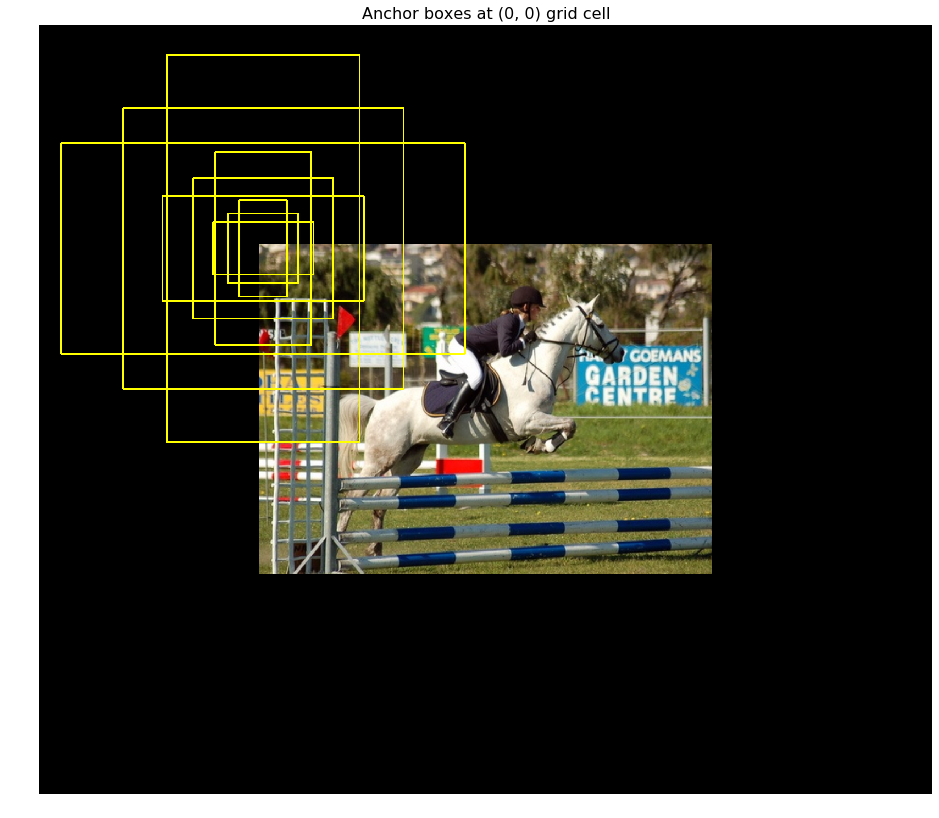

In [15]:
MARGIN = 400
GRID_IDX = (0, 0)  # upper bound: [grid_height - 1, grid_width - 1]
SHOW_ALL = False

img_with_margin = np.zeros((sample_data['image_size'][0] + MARGIN * 2, sample_data['image_size'][1] + MARGIN * 2, 3)).astype(np.uint8)
img_with_margin[
    MARGIN:MARGIN + sample_data['image_size'][0], MARGIN:MARGIN + sample_data['image_size'][1], :
] = sample_data['image'][:, :, [2, 1, 0]]

for idx, box in enumerate(anchor_boxes):
    if not SHOW_ALL and idx // cfg.NUM_ANCHORS_PER_GRID != GRID_IDX[0] * num_grids_w + GRID_IDX[1]:
        continue
    box = box + MARGIN
    cv2.rectangle(img_with_margin, (box[0], box[1]), (box[2], box[3]), color=(255, 255, 0), thickness=2)
    print('[Box # {}] Shape: ({:3}, {:3}) -> Size: {:6d},  Scale: {:.3f}'.format(
        idx % cfg.NUM_ANCHORS_PER_GRID, int(box[2] - box[0]), int(box[3] - box[1]),
        int((box[2] - box[0]) * (box[3] - box[1])), (box[2] - box[0]) / (box[3] - box[1])
    ))

plt.figure(figsize=(16, 16))
plt.title('Anchor boxes at {} grid cell'.format(GRID_IDX), fontdict={'fontsize': 16})
plt.imshow(img_with_margin)
plt.axis('off')
plt.show()

# 4. Conv Feature Extracting

In [16]:
def extract_conv_feats(image, is_training):
    """
    Args:
        image (np.ndarray): [1, image_height, image_width, image_channel]
        is_training (bool)
    
    Returns:
        conv_feats (Tensor): [1, height/stride, width/stride, depth]
    """
    net = slim.repeat(image, 2, slim.conv2d, 64, [3, 3], trainable=False, scope='conv1')  # Freezed
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool1')
    net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], trainable=False, scope='conv2')  # Freezed
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool2')
    net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], trainable=is_training, scope='conv3')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool3')
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], trainable=is_training, scope='conv4')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool4')
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], trainable=is_training, scope='conv5')
    conv_feats = net
    
    return conv_feats

In [17]:
conv_feats = extract_conv_feats(inputs['image'], cfg.IS_TRAINING)

intermediates['conv_feats'] = conv_feats

### Check up the transformed shape.

In [18]:
sess.run(tf.global_variables_initializer())
 
conv_feats = intermediates['conv_feats'].eval(feed_dict=sample_feed_dict)

print('Shape of `conv_feats`: {}'.format(intermediates['conv_feats'].shape))

print('\nShape of the input image: {}'.format(sample_data['image'].shape))
print('Total stride: {}'.format(cfg.ARCHI.TOTAL_STRIDE))
print('Expected size of `conv_feats`: ({}, {})'.format(
    int(np.ceil(sample_data['image_size'][0] / cfg.ARCHI.TOTAL_STRIDE)),
    int(np.ceil(sample_data['image_size'][1] / cfg.ARCHI.TOTAL_STRIDE)),
))

print('\nShape of the evaluated `conv_feats`: {}'.format(conv_feats.shape))

assert conv_feats.shape[1] == int(np.ceil(sample_data['image_size'][0] / cfg.ARCHI.TOTAL_STRIDE))
assert conv_feats.shape[2] == int(np.ceil(sample_data['image_size'][1] / cfg.ARCHI.TOTAL_STRIDE))

Shape of `conv_feats`: (1, ?, ?, 512)

Shape of the input image: (600, 825, 3)
Total stride: 16
Expected size of `conv_feats`: (38, 52)

Shape of the evaluated `conv_feats`: (1, 38, 52, 512)


# 5. Region Proposal Network (RPN) Prediction

In [19]:
def _reshape_channel(bottom, num_chanels, name=None):
    input_shape = tf.shape(bottom)
    to_caffe = tf.transpose(bottom, [0, 3, 1, 2])
    reshaped = tf.reshape(to_caffe, tf.concat(axis=0, values=[[1, num_chanels, -1], [input_shape[2]]]))
    to_tf = tf.transpose(reshaped, [0, 2, 3, 1], name=name)
    return to_tf

### Intermediate layer of RPN

In [20]:
rpn_intermediate = slim.conv2d(conv_feats, cfg.ARCHI.RPN_CHANNELS, [3, 3], trainable=cfg.IS_TRAINING)
intermediates['rpn_intermediate'] = rpn_intermediate

### Prediction 1: Objectiveness (classification)

In [21]:
# Output logits
rpn_cls_scores = slim.conv2d(  # [H/16, W/16, num_anchors_per_grid * 2]
    rpn_intermediate,
    cfg.NUM_ANCHORS_PER_GRID * 2, [1, 1], trainable=cfg.IS_TRAINING,
    weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
    weights_regularizer=tf.contrib.layers.l2_regularizer(cfg.TRAIN.WEIGHT_DECAY),
    padding='VALID', activation_fn=None
)
intermediates['rpn_cls_scores'] = rpn_cls_scores
rpn_cls_scores_reshaped = _reshape_channel(rpn_cls_scores, 2, 'rpn_cls_scores_reshaped')
checkups['rpn_cls_scores_reshaped'] = rpn_cls_scores_reshaped

# Class probability distribution (by softmax)
rpn_cls_prob_reshaped = tf.reshape(
    tf.nn.softmax(tf.reshape(rpn_cls_scores_reshaped, (-1, 2))), tf.shape(rpn_cls_scores_reshaped),
    name='rpn_cls_prob_reshaped'
)
checkups['rpn_cls_prob_reshaped'] = rpn_cls_prob_reshaped
rpn_cls_prob = _reshape_channel(rpn_cls_prob_reshaped, cfg.NUM_ANCHORS_PER_GRID * 2, name='rpn_cls_prob')
predictions['rpn_cls_prob'] = rpn_cls_prob

# Class prediction (by argmax)
rpn_cls_pred = tf.argmax(tf.reshape(rpn_cls_scores_reshaped, (-1, 2)), axis=1, name='rpn_cls_pred')  # [num_anchor_boxes]
predictions['rpn_cls_pred'] = rpn_cls_pred

### Check up the shapes.

In [22]:
sess.run(tf.global_variables_initializer())

rpn_cls_scores, rpn_cls_scores_reshaped, rpn_cls_prob, rpn_cls_prob_reshaped, rpn_cls_pred = sess.run(
    [intermediates['rpn_cls_scores'], checkups['rpn_cls_scores_reshaped'],
     predictions['rpn_cls_prob'], checkups['rpn_cls_prob_reshaped'],
     predictions['rpn_cls_pred']],
    feed_dict=sample_feed_dict
)

print('Shape of `rpn_cls_scores`: {}'.format(rpn_cls_scores.shape))
# print('Shape of `rpn_cls_scores_reshaped`: {}'.format(rpn_cls_scores_reshaped.shape))

print('\nShape of `rpn_cls_prob`: {}'.format(rpn_cls_prob.shape))
# print('Shape of `rpn_cls_prob_reshaped`: {}'.format(rpn_cls_prob_reshaped.shape))

print('\nShape of `rpn_cls_pred`: {}'.format(rpn_cls_pred.shape))

assert rpn_cls_pred.shape[0] == anchor_boxes.shape[0]

Shape of `rpn_cls_scores`: (1, 38, 52, 18)

Shape of `rpn_cls_prob`: (1, 38, 52, 18)

Shape of `rpn_cls_pred`: (17784,)


### Prediction 2: Box parameters (regression)

In [23]:
rpn_bbox_params = slim.conv2d(
    rpn_intermediate,
    cfg.NUM_ANCHORS_PER_GRID * 4, [1, 1], trainable=cfg.IS_TRAINING,
    weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
    weights_regularizer=tf.contrib.layers.l2_regularizer(cfg.TRAIN.WEIGHT_DECAY),
    padding='VALID', activation_fn=None
)
predictions['rpn_bbox_params'] = rpn_bbox_params

### Check up the shapes.

In [24]:
sess.run(tf.global_variables_initializer())

rpn_bbox_params = predictions['rpn_bbox_params'].eval(feed_dict=sample_feed_dict)

print('Shape of `rpn_bbox_params`: {}'.format(rpn_bbox_params.shape))

Shape of `rpn_bbox_params`: (1, 38, 52, 36)


# 6. Anchor Box Transformation

In [25]:
def transform_bboxes(boxes, deltas):
    """
    Args:
        boxes: [num_boxes, 4], (xmin, ymin, xmax, ymax) formed
        deltas: [num_boxes, 4], (tx, ty, tw, th)
    """
    boxes = tf.cast(boxes, deltas.dtype)
    
    # Compute size and center coordinates of the boxex.
    widths = tf.subtract(boxes[:, 2], boxes[:, 0]) + 1.0
    heights = tf.subtract(boxes[:, 3], boxes[:, 1]) + 1.0
    ctr_x = tf.add(boxes[:, 0], widths * 0.5)
    ctr_y = tf.add(boxes[:, 1], heights * 0.5)

    tx, ty, tw, th = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    transformed_ctr_x = tf.add(tf.multiply(tx, widths), ctr_x)
    transformed_ctr_y = tf.add(tf.multiply(ty, heights), ctr_y)
    transformed_w = tf.multiply(tf.exp(tw), widths)
    transformed_h = tf.multiply(tf.exp(th), heights)

    transformed_xmin = tf.subtract(transformed_ctr_x, transformed_w * 0.5)
    transformed_ymin = tf.subtract(transformed_ctr_y, transformed_h * 0.5)
    transformed_xmax = tf.add(transformed_ctr_x, transformed_w * 0.5)
    transformed_ymax = tf.add(transformed_ctr_y, transformed_h * 0.5)

    return tf.stack([transformed_xmin, transformed_ymin, transformed_xmax, transformed_ymax], axis=1)

def clip_bboxes(boxes, img_shape):
    """
    Args:
        boxes: [n_boxes, 4]
        img_shape: [2]
    """
    b0 = tf.maximum(tf.minimum(boxes[:, 0], img_shape[1] - 1), 0)
    b1 = tf.maximum(tf.minimum(boxes[:, 1], img_shape[0] - 1), 0)
    b2 = tf.maximum(tf.minimum(boxes[:, 2], img_shape[1] - 1), 0)
    b3 = tf.maximum(tf.minimum(boxes[:, 3], img_shape[0] - 1), 0)
    
    return tf.stack([b0, b1, b2, b3], axis=1)

In [26]:
transformed_anchor_boxes = transform_bboxes(
    intermediates['anchor_boxes'],
    tf.reshape(predictions['rpn_bbox_params'], (-1, 4))
)
checkups['transformed_anchor_boxes'] = transformed_anchor_boxes
proposal_boxes_before_nms = clip_bboxes(transformed_anchor_boxes, inputs['image_size'])
intermediates['proposal_boxes_before_nms'] = proposal_boxes_before_nms

### Check up the shapes.

In [27]:
print('Shape of `anchor_boxes`: {}'.format(intermediates['anchor_boxes'].eval(feed_dict=sample_feed_dict).shape))
print('\nShape after transformation: {}'.format(checkups['transformed_anchor_boxes'].eval(feed_dict=sample_feed_dict).shape))
print('\nShape after clipping`: {}'.format(intermediates['proposal_boxes_before_nms'].eval(feed_dict=sample_feed_dict).shape))

Shape of `anchor_boxes`: (17784, 4)

Shape after transformation: (17784, 4)

Shape after clipping`: (17784, 4)


# 7. Non Maximum Suppression

In [28]:
# Get the objectness scores.
obj_scores = predictions['rpn_cls_prob'][:, :, :, cfg.NUM_ANCHORS_PER_GRID:]  # [1, num_grids_h, num_grids_w, num_anchors_per_gird]
obj_scores = tf.reshape(obj_scores, (-1,))  # [num_anchor_boxes]
checkups['obj_scores'] = obj_scores

# Hyperparameters for NMS
post_nms_top_n = cfg['TRAIN' if cfg.IS_TRAINING else 'TEST'].RPN_POST_NMS_TOP_N
nms_thres = cfg['TRAIN' if cfg.IS_TRAINING else 'TEST'].RPN_NMS_THRES

nms_indices = tf.image.non_max_suppression(
    intermediates['proposal_boxes_before_nms'], obj_scores, max_output_size=post_nms_top_n, iou_threshold=nms_thres
)
checkups['nms_indices'] = nms_indices
num_boxes_after_nms = tf.shape(nms_indices)[0]

proposal_boxes = tf.gather(intermediates['proposal_boxes_before_nms'], nms_indices)  # [num_boxes_after_nms, 4]
intermediates['proposal_boxes'] = proposal_boxes

proposal_scores = tf.reshape(tf.gather(obj_scores, nms_indices), (-1, 1))  # [num_boxes_after_nms, 1]
intermediates['proposal_scores'] = proposal_scores

In [29]:
print('Shape of `obj_scores`: {}'.format(checkups['obj_scores'].eval(feed_dict=sample_feed_dict).shape))

print('\npost_nms_top_n: {}, nms_thres: {}'.format(post_nms_top_n, nms_thres))

print('\nShape of `nms_indices`: {}'.format(checkups['nms_indices'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `proposal_boxes`: {}'.format(intermediates['proposal_boxes'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `proposal_scores`: {}'.format(intermediates['proposal_scores'].eval(feed_dict=sample_feed_dict).shape))

Shape of `obj_scores`: (17784,)

post_nms_top_n: 2000, nms_thres: 0.7

Shape of `nms_indices`: (2000,)
Shape of `proposal_boxes`: (2000, 4)
Shape of `proposal_scores`: (2000, 1)


# 8. ROI Pooling

In [30]:
ceiled_img_h = tf.to_float(tf.shape(intermediates['conv_feats'])[1]) * np.float32(cfg.ARCHI.TOTAL_STRIDE)
ceiled_img_w = tf.to_float(tf.shape(intermediates['conv_feats'])[2]) * np.float32(cfg.ARCHI.TOTAL_STRIDE)                

xmin = intermediates['proposal_boxes'][:, 0:1] / ceiled_img_w
ymin = intermediates['proposal_boxes'][:, 1:2] / ceiled_img_h
xmax = intermediates['proposal_boxes'][:, 2:3] / ceiled_img_w
ymax = intermediates['proposal_boxes'][:, 3:4] / ceiled_img_h

normalized_boxes = tf.concat([ymin, xmin, ymax, xmax], axis=1)  # [num_proposal_boxes, 4]

batch_indices = tf.zeros((tf.shape(normalized_boxes)[0],), dtype=tf.int32)

pre_pool_size = cfg.ARCHI.POOLING_SIZE * 2

roi_pooled_feats = tf.image.crop_and_resize(
    intermediates['conv_feats'], normalized_boxes, batch_indices, [pre_pool_size, pre_pool_size], name='roi_pooled_feats'
)
intermediates['roi_pooled_feats'] = roi_pooled_feats

### Check up the shapes.

In [31]:
print('Shape of `roi_pooled_feats`: {}'.format(intermediates['roi_pooled_feats'].eval(feed_dict=sample_feed_dict).shape))

Shape of `roi_pooled_feats`: (2000, 14, 14, 512)


# 9. FC Feature Extracting

In [32]:
def extract_fc_feats(pooled_rois, is_training):
    """
    Args:
        poold_rois: [num_rois, roi_height, roi_width, image_channel]
        is_training (bool)
        
    Returns:
        fc_feats (Tensor): [num_rois, depth]
    """
    pooled_rois_flat = slim.flatten(pooled_rois, scope='flatten')
    fc6 = slim.fully_connected(pooled_rois_flat, 4096, scope='fc6')
    if is_training:
        fc6 = slim.dropout(fc6, keep_prob=0.5, is_training=True, scope='dropout6')
    fc7 = slim.fully_connected(fc6, 4096, scope='fc7')
    if is_training:
        fc7 = slim.dropout(fc7, keep_prob=0.5, is_training=True, scope='dropout7')
    fc_feats = fc7

    return fc_feats

In [33]:
fc_feats = extract_fc_feats(intermediates['roi_pooled_feats'], cfg.IS_TRAINING)

intermediates['fc_feats'] = fc_feats

### Check up the shapes.

In [34]:
sess.run(tf.global_variables_initializer())

print('Shape of `fc_feats`: {}'.format(intermediates['fc_feats'].eval(feed_dict=sample_feed_dict).shape))

Shape of `fc_feats`: (2000, 4096)


# 10. Fast R-CNN Prediction

### Prediction 1: Class probabilities (classification)

In [35]:
cls_scores = slim.fully_connected(
    intermediates['fc_feats'], cfg.DATA.NUM_CLASSES,
    weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
    trainable=cfg.IS_TRAINING, activation_fn=None, scope='cls_scores'
)
predictions['cls_scores'] = cls_scores

cls_prob = tf.nn.softmax(cls_scores)
predictions['cls_prob'] = cls_prob
cls_pred = tf.argmax(cls_scores, axis=1, name='cls_pred')
predictions['cls_pred'] = cls_pred

### Check up the shapes.

In [36]:
sess.run(tf.global_variables_initializer())

print('Shape of `cls_scores`: {}'.format(predictions['cls_scores'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `cls_prob`: {}'.format(predictions['cls_prob'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `cls_pred`: {}'.format(predictions['cls_pred'].eval(feed_dict=sample_feed_dict).shape))

Shape of `cls_scores`: (2000, 21)
Shape of `cls_prob`: (2000, 21)
Shape of `cls_pred`: (2000,)


### Prediction 2: Box parameters (regression)

In [37]:
bbox_params = slim.fully_connected(
    intermediates['fc_feats'], cfg.DATA.NUM_CLASSES * 4,
    weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.001),
    trainable=cfg.IS_TRAINING, activation_fn=None, scope='bbox_params'
)
predictions['bbox_params'] = bbox_params

### Check up the shapes.

In [38]:
sess.run(tf.global_variables_initializer())

print('Shape of `bbox_params`: {}'.format(predictions['bbox_params'].eval(feed_dict=sample_feed_dict).shape))

Shape of `bbox_params`: (2000, 84)


# 11. Anchor Box Targeting & Batch Sampling

In [39]:
def bbox_overlaps(boxes1, boxes2):
    """Compute the IOUs between the two sets of boxes.
    
    Args:
        boxes1 (numpy.ndarray): [num_boxes1, 4]-D array
        boxes2 (numpy.ndarray): [num_boxes2, 4]-D array
    
    Each of a box comprises 4 coordinate values in [xmin, ymin, xmax, ymax] order.
        
    Returns:
        overlaps (numpy.ndarray): [num_boxes1, num_boxes2]-D array, which is the distance matrix of the two sets of boxes
    """
    # Compute the areas of `boxes1` and `boxes2`.
    area1 = (boxes1[:, 2] - boxes1[:, 0] + 1) * (boxes1[:, 3] - boxes1[:, 1] + 1)  # [num_boxes1]
    area2 = (boxes2[:, 2] - boxes2[:, 0] + 1) * (boxes2[:, 3] - boxes2[:, 1] + 1)  # [num_boxes2]
    
    # Compute the areas of the intersections.
    intersection_h = np.maximum(
        (np.minimum(np.expand_dims(boxes1[:, 3], axis=1), boxes2[:, 3]) -
         np.maximum(np.expand_dims(boxes1[:, 1], axis=1), boxes2[:, 1]) + 1),
        0
    )  # [num_boxes1, num_boxes2]-D
    intersection_w = np.maximum(
        (np.minimum(np.expand_dims(boxes1[:, 2], axis=1), boxes2[:, 2]) -
         np.maximum(np.expand_dims(boxes1[:, 0], axis=1), boxes2[:, 0]) + 1),
        0
    )  # [num_boxes1, num_boxes2]-D
    intersection = intersection_h * intersection_w  # [num_boxes1, num_boxes2]-D

    # Compute the areas of the unions.
    union = np.maximum(
        np.expand_dims(area1, 1) + area2 - intersection,
        np.finfo(float).eps
    )
    
    # Compute IOU values.
    iou = intersection / union

    return iou

### Usage of the `bbox_overlaps` method

In [51]:
boxes1 = np.array([[10, 10, 50, 50], [80, 80, 120, 120]])
boxes2 = np.array([[30, 10, 70, 50], [80, 80, 120, 120], [80, 80, 120, 160]])

print(bbox_overlaps(boxes1, boxes2))

[[0.3442623  0.         0.        ]
 [0.         1.         0.50617284]]


In [42]:
def get_bbox_deltas(src_bboxes, dst_bboxes):
    src_widths = src_bboxes[:, 2] - src_bboxes[:, 0] + 1.0
    src_heights = src_bboxes[:, 3] - src_bboxes[:, 1] + 1.0
    src_ctr_x = src_bboxes[:, 0] + 0.5 * src_widths
    src_ctr_y = src_bboxes[:, 1] + 0.5 * src_heights

    dst_widths = dst_bboxes[:, 2] - dst_bboxes[:, 0] + 1.0
    dst_heights = dst_bboxes[:, 3] - dst_bboxes[:, 1] + 1.0
    dst_ctr_x = dst_bboxes[:, 0] + 0.5 * dst_widths
    dst_ctr_y = dst_bboxes[:, 1] + 0.5 * dst_heights

    targets_dx = (dst_ctr_x - src_ctr_x) / src_widths
    targets_dy = (dst_ctr_y - src_ctr_y) / src_heights
    targets_dw = np.log(dst_widths / src_widths)
    targets_dh = np.log(dst_heights / src_heights)

    targets = np.vstack((targets_dx, targets_dy, targets_dw, targets_dh)).transpose()
    return targets

In [43]:
def _unmap(data, count, indices, fill=0):
    """Unmap a subset of item (data) back to the original set of items (of size count)
    """
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=np.float32)
        ret.fill(fill)
        ret[indices] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[indices, :] = data
    return ret

def _compute_targets(bboxes, target_bboxes):
    """Compute bounding-box regression targets for an image.
    """
    assert bboxes.shape[0] == target_bboxes.shape[0]
    bbox_deltas = get_bbox_deltas(bboxes, target_bboxes[:, :4]).astype(np.float32, copy=False)
    return bbox_deltas

def anchor_target_layer(rpn_cls_scores, gt_boxes, image_size, anchors):
    A = cfg.NUM_ANCHORS_PER_GRID
    num_anchors = anchors.shape[0]
    K = num_anchors / A

    num_grids_h, num_grids_w = rpn_cls_scores.shape[1:3]

    # Only keep anchors inside the image border.
    inds_inside = np.where(
        (anchors[:, 0] >= 0) & (anchors[:, 1] >= 0) & (anchors[:, 2] < image_size[1]) & (anchors[:, 3] < image_size[0])
    )[0]
    anchors = anchors[inds_inside, :]

    # Create labels. (1: Positive, 0: Negative, -1: Ignore)
    labels = np.empty((len(inds_inside),), dtype=np.float32)  # [num_inside_anchor_boxes]
    labels.fill(-1)  # Default to be ignored

    # Compute the IOU matrix (distance matrix) between the anchor boxes and GT boxes.
    overlaps = bbox_overlaps(  # [num_anchor_boxes, num_gt_boxes]-D matrix
        np.ascontiguousarray(anchors, dtype=np.float),
        np.ascontiguousarray(gt_boxes, dtype=np.float)
    )
    
    argmax_overlaps = overlaps.argmax(axis=1)  # [num_anchor_boxes]
    max_overlaps = overlaps.max(axis=1)  # [num_anchor_boxes]
    
    gt_argmax_overlaps = overlaps.argmax(axis=0)  # [num_gt_boxes]
    gt_max_overlaps = overlaps.max(axis=0)  # [num_gt_boxes]
    # Indices of the anchor boxes which is the best match of at least 1 GT box.
    # Not perfect, but practically work!
    gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]  

    # Assign negative labels first so that positive labels can clobber them.
    labels[max_overlaps < cfg.TRAIN.RPN_NEGATIVE_OVERLAP] = 0

    # fg label: for each gt, anchor with highest overlap
    labels[gt_argmax_overlaps] = 1

    # fg label: above threshold IOU
    labels[max_overlaps >= cfg.TRAIN.RPN_POSITIVE_OVERLAP] = 1

    # Subsample positive labels if we have too many
    num_fg = int(cfg.TRAIN.RPN_FG_FRACTION * cfg.TRAIN.RPN_BATCHSIZE)
    fg_inds = np.where(labels == 1)[0]
    if len(fg_inds) > num_fg:
        disable_inds = npr.choice(fg_inds, size=(len(fg_inds) - num_fg), replace=False)
        labels[disable_inds] = -1  # Ignore the subsampled.

    # Subsample negative labels if we have too many
    num_bg = cfg.TRAIN.RPN_BATCHSIZE - np.sum(labels == 1)
    bg_inds = np.where(labels == 0)[0]
    if len(bg_inds) > num_bg:
        disable_inds = npr.choice(bg_inds, size=(len(bg_inds) - num_bg), replace=False)
        labels[disable_inds] = -1  # Ignore the subsampled.

    # Compute the bbox targets of all the inside anchor boxes.
    bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
    bbox_targets = _compute_targets(anchors, gt_boxes[argmax_overlaps, :])

    # Non-positive samples are supposed to be masked.
    bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
    # Only the positive ones have regression targets
    bbox_inside_weights[labels == 1, :] = np.array(cfg.TRAIN.RPN_BBOX_INSIDE_WEIGHTS)

    bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
    # Currently uniform weighting of examples
    # Able to weight positive and negative samples differently here!
    num_examples = np.sum(labels >= 0)
    positive_weights = np.ones((1, 4)) * 1.0 / num_examples
    negative_weights = np.ones((1, 4)) * 1.0 / num_examples
    bbox_outside_weights[labels == 1, :] = positive_weights
    bbox_outside_weights[labels == 0, :] = negative_weights

    # Map up to original set of anchors (only inside anchor boxes -> all anchor boxes)
    labels = _unmap(labels, num_anchors, inds_inside, fill=-1)  # Fill to be `ignore` case
    bbox_targets = _unmap(bbox_targets, num_anchors, inds_inside, fill=0)
    bbox_inside_weights = _unmap(bbox_inside_weights, num_anchors, inds_inside, fill=0)  # zero weights -> not learned
    bbox_outside_weights = _unmap(bbox_outside_weights, num_anchors, inds_inside, fill=0)  # zero weights -> not learned

    # Reshape tensors into a grid cell form.
    labels = labels.reshape((1, num_grids_h, num_grids_w, A))
    rpn_labels = labels

    bbox_targets = bbox_targets.reshape((1, num_grids_h, num_grids_w, A * 4))
    rpn_bbox_targets = bbox_targets
    
    bbox_inside_weights = bbox_inside_weights.reshape((1, num_grids_h, num_grids_w, A * 4))
    rpn_bbox_inside_weights = bbox_inside_weights

    bbox_outside_weights = bbox_outside_weights.reshape((1, num_grids_h, num_grids_w, A * 4))
    rpn_bbox_outside_weights = bbox_outside_weights
    
    return rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights

In [44]:
rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = tf.py_func(
    anchor_target_layer,
    [intermediates['rpn_cls_scores'], inputs['gt_boxes'], inputs['image_size'], intermediates['anchor_boxes']],
    [tf.float32, tf.float32, tf.float32, tf.float32],
    name='anchor_target'
)
intermediates['rpn_labels'] = rpn_labels
intermediates['rpn_bbox_targets'] = rpn_bbox_targets
intermediates['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
intermediates['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights

### Check up the shapes and sampled batches.

In [45]:
rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = sess.run(
    [intermediates['rpn_labels'], intermediates['rpn_bbox_targets'],
     intermediates['rpn_bbox_inside_weights'], intermediates['rpn_bbox_outside_weights']],
    feed_dict=sample_feed_dict
)

print('Shape of `rpn_labels`: {}'.format(intermediates['rpn_labels'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `rpn_bbox_targets`: {}'.format(intermediates['rpn_bbox_targets'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `rpn_bbox_inside_weights`: {}'.format(intermediates['rpn_bbox_inside_weights'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `rpn_bbox_outside_weights`: {}'.format(intermediates['rpn_bbox_outside_weights'].eval(feed_dict=sample_feed_dict).shape))

print('\nNumber of positive samples: {}'.format(np.count_nonzero(rpn_labels == 1)))
print('Number of negative samples: {}'.format(np.count_nonzero(rpn_labels == 0)))
print('Number of ignored samples: {}'.format(np.count_nonzero(rpn_labels == -1)))
print('P + N + I = {}'.format(
    np.count_nonzero(rpn_labels == 1) + np.count_nonzero(rpn_labels == 0) + np.count_nonzero(rpn_labels == -1)
))

print('\nTotal number of anchor boxes: {}'.format(anchor_boxes.shape[0]))

assert np.count_nonzero(rpn_labels == 1) + np.count_nonzero(rpn_labels == 0) + np.count_nonzero(rpn_labels == -1) == anchor_boxes.shape[0]

Shape of `rpn_labels`: (1, 38, 52, 9)
Shape of `rpn_bbox_targets`: (1, 38, 52, 36)
Shape of `rpn_bbox_inside_weights`: (1, 38, 52, 36)
Shape of `rpn_bbox_outside_weights`: (1, 38, 52, 36)

Number of positive samples: 68
Number of negative samples: 188
Number of ignored samples: 17528
P + N + I = 17784

Total number of anchor boxes: 17784


# 12. Proposal Box Targeting & Batch Sampling

In [46]:
def _compute_targets(src_bboxes, dst_bboxes, labels):
    """Compute bounding-box regression targets for an image.
    """
    targets = get_bbox_deltas(src_bboxes, dst_bboxes)
    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Optionally normalize targets by a precomputed mean and stdev
        targets = ((targets - np.array(cfg.TRAIN.BBOX_NORMALIZE_MEANS)) / np.array(cfg.TRAIN.BBOX_NORMALIZE_STDS))
    return np.hstack((labels[:, np.newaxis], targets)).astype(np.float32, copy=False)

def _get_bbox_regression_labels(bbox_target_data, num_classes):
    """Bounding-box regression targets (bbox_target_data) are stored in a
    compact form N x (class, tx, ty, tw, th)

    This function expands those targets into the 4-of-4*K representation used
    by the network (i.e. only one class has non-zero targets).

    Returns:
      bbox_target (ndarray): N x 4K blob of regression targets
      bbox_inside_weights (ndarray): N x 4K blob of loss weights
    """
    clss = bbox_target_data[:, 0]
    bbox_targets = np.zeros((clss.size, 4 * num_classes), dtype=np.float32)
    bbox_inside_weights = np.zeros(bbox_targets.shape, dtype=np.float32)
    inds = np.where(clss > 0)[0]
    for ind in inds:
        cls = clss[ind]
        start = int(4 * cls)
        end = start + 4
        bbox_targets[ind, start:end] = bbox_target_data[ind, 1:]
        bbox_inside_weights[ind, start:end] = cfg.TRAIN.BBOX_INSIDE_WEIGHTS
    return bbox_targets, bbox_inside_weights


def _sample_rois(all_rois, all_scores, gt_boxes, fg_rois_per_image, rois_per_image, num_classes):
    """Generate a random sample of RoIs comprising foreground and background examples.
    """
    # (num_rois, num_gt_boxes)-D distance(IOU) matrix
    overlaps = bbox_overlaps(
        np.ascontiguousarray(all_rois, dtype=np.float),
        np.ascontiguousarray(gt_boxes, dtype=np.float)
    )
    gt_assignment = overlaps.argmax(axis=1)  # [num_rois], Matched GT box indices of the ROIS
    max_overlaps = overlaps.max(axis=1)  # [num_rois], IOU values of the best matchs
    labels = gt_boxes[gt_assignment, 4]  # [num_rois, 4]

    # Select foreground RoIs as those with >= FG_THRESH overlap
    fg_inds = np.where(max_overlaps >= cfg.TRAIN.FG_THRESH)[0]
    # Guard against the case when an image has fewer than fg_rois_per_image
    # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
    bg_inds = np.where((max_overlaps < cfg.TRAIN.BG_THRESH_HI) & (max_overlaps >= cfg.TRAIN.BG_THRESH_LO))[0]

    # Small modification to the original version where we ensure a fixed number of regions are sampled
    if fg_inds.size > 0 and bg_inds.size > 0:
        fg_rois_per_image = min(fg_rois_per_image, fg_inds.size)
        fg_inds = npr.choice(fg_inds, size=int(fg_rois_per_image), replace=False)
        bg_rois_per_image = rois_per_image - fg_rois_per_image
        to_replace = bg_inds.size < bg_rois_per_image
        bg_inds = npr.choice(bg_inds, size=int(bg_rois_per_image), replace=to_replace)
    elif fg_inds.size > 0:
        to_replace = fg_inds.size < rois_per_image
        fg_inds = npr.choice(fg_inds, size=int(rois_per_image), replace=to_replace)
        fg_rois_per_image = rois_per_image
    elif bg_inds.size > 0:
        to_replace = bg_inds.size < rois_per_image
        bg_inds = npr.choice(bg_inds, size=int(rois_per_image), replace=to_replace)
        fg_rois_per_image = 0
    else:
        import pdb
        pdb.set_trace()

    # The indices that we're selecting (both fg and bg)
    keep_inds = np.append(fg_inds, bg_inds)
    # Select sampled values from various arrays:
    labels = labels[keep_inds]
    # Clamp labels for the background RoIs to 0
    labels[int(fg_rois_per_image):] = 0
    rois = all_rois[keep_inds]
    roi_scores = all_scores[keep_inds]

    bbox_target_data = _compute_targets(rois, gt_boxes[gt_assignment[keep_inds], :4], labels)

    bbox_targets, bbox_inside_weights = _get_bbox_regression_labels(bbox_target_data, num_classes)

    return labels, rois, roi_scores, bbox_targets, bbox_inside_weights


def proposal_target_layer(proposal_boxes, proposal_scores, gt_boxes, num_classes):
    """
    Assign object detection proposals to ground-truth targets.
    Produces proposal classification labels and bounding-box regression targets.
    Args:
        proposal_boxes: [num_proposal_boxes, 4]
        proposal_scores: [num_proposal_boxes, 1]
    """
    all_rois = proposal_boxes
    all_scores = proposal_scores

    num_images = 1
    rois_per_image = cfg.TRAIN.BATCH_SIZE / num_images
    fg_rois_per_image = np.round(cfg.TRAIN.FG_FRACTION * rois_per_image)

    # Sample rois with classification labels and bounding box regression targets
    labels, rois, roi_scores, bbox_targets, bbox_inside_weights = _sample_rois(
        all_rois, all_scores, gt_boxes, fg_rois_per_image, rois_per_image, num_classes
    )

    rois = rois.reshape(-1, 4)
    roi_scores = roi_scores.reshape(-1)
    labels = labels.reshape(-1, 1)
    bbox_targets = bbox_targets.reshape(-1, num_classes * 4)
    bbox_inside_weights = bbox_inside_weights.reshape(-1, num_classes * 4)
    bbox_outside_weights = np.array(bbox_inside_weights > 0).astype(np.float32)

    return rois, roi_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights

In [47]:
sampled_proposal_boxes, sampled_proposal_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights = tf.py_func(
    proposal_target_layer,
    [intermediates['proposal_boxes'], intermediates['proposal_scores'], inputs['gt_boxes'], cfg.DATA.NUM_CLASSES],
    [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32],
    name='proposal_target'
)

intermediates['sampled_proposal_boxes'] = sampled_proposal_boxes
intermediates['sampled_proposal_scores'] = sampled_proposal_scores
intermediates['labels'] = labels
intermediates['bbox_targets'] = bbox_targets
intermediates['bbox_inside_weights'] = bbox_inside_weights
intermediates['bbox_outside_weights'] = bbox_outside_weights

### Check up the shapes.

In [48]:
sampled_proposal_boxes, sampled_proposal_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights = sess.run(
    [intermediates['sampled_proposal_boxes'], intermediates['sampled_proposal_scores'],
     intermediates['labels'], intermediates['bbox_targets'],
     intermediates['bbox_inside_weights'], intermediates['bbox_outside_weights']],
    feed_dict=sample_feed_dict
)

print('Shape of `sampled_proposal_boxes`: {}'.format(intermediates['sampled_proposal_boxes'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `sampled_proposal_scores`: {}'.format(intermediates['sampled_proposal_scores'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `labels`: {}'.format(intermediates['labels'].eval(feed_dict=sample_feed_dict).shape))
print('Shape of `bbox_targets`: {}'.format(intermediates['bbox_targets'].eval(feed_dict=sample_feed_dict).shape))

Shape of `sampled_proposal_boxes`: (256, 4)
Shape of `sampled_proposal_scores`: (256,)
Shape of `labels`: (256, 1)
Shape of `bbox_targets`: (256, 84)


# 13. Compose loss function.

In [49]:
def _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = tf.abs(in_box_diff)
    smoothL1_sign = tf.stop_gradient(tf.to_float(tf.less(abs_in_box_diff, 1. / sigma_2)))
    in_loss_box = (
        tf.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign +
        (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    )
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = tf.reduce_mean(tf.reduce_sum(out_loss_box, axis=dim))
    return loss_box

def compose_losses(sigma_rpn=3.0):
    # RPN, class loss
    rpn_cls_scores = tf.reshape(intermediates['rpn_cls_scores'], [-1, 2])
    rpn_labels = tf.reshape(intermediates['rpn_labels'], [-1])
    rpn_select = tf.where(tf.not_equal(rpn_labels, -1))
    rpn_cls_scores = tf.reshape(tf.gather(rpn_cls_scores, rpn_select), [-1, 2])
    rpn_labels = tf.reshape(tf.gather(rpn_labels, rpn_select), [-1])
    rpn_cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=rpn_cls_scores, labels=tf.cast(rpn_labels, tf.int64))
    )

    # RPN, bbox loss
    rpn_bbox_pred = predictions['rpn_bbox_params']
    rpn_bbox_targets = intermediates['rpn_bbox_targets']
    rpn_bbox_inside_weights = intermediates['rpn_bbox_inside_weights']
    rpn_bbox_outside_weights = intermediates['rpn_bbox_outside_weights']
    rpn_loss_box = _smooth_l1_loss(
        rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights,
        sigma=sigma_rpn, dim=[1, 2, 3]
    )

    # RCNN, class loss
    cls_scores = predictions['cls_scores']
    labels = tf.reshape(intermediates['labels'], [-1])
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=cls_scores, labels=tf.cast(labels, tf.int64))
    )

    # RCNN, bbox loss
    bbox_pred = predictions['bbox_params']
    bbox_targets = intermediates['bbox_targets']
    bbox_inside_weights = intermediates['bbox_inside_weights']
    bbox_outside_weights = intermediates['bbox_outside_weights']
    loss_box = _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights)

    
    # Regularization term
    regularization_loss = tf.add_n(tf.losses.get_regularization_losses(), 'regu')

    # Total loss (end-to-end manner)
    loss = cross_entropy + loss_box + rpn_cross_entropy + rpn_loss_box + regularization_loss

    return loss

In [50]:
total_loss = compose_losses()